Import Block

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

Data Exploratory


In [2]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/christiandoxa/usahaq_ml/master/Dataset/Dataset%20Bahan%20Pokok/data-harga-ayam-broiler-malang-2017-2021.csv?token=ARB4LTGFT6DKJ72LIHMFH43AX3QO4 \
    -O /tmp/chicken.csv

--2021-06-01 03:23:54--  https://raw.githubusercontent.com/christiandoxa/usahaq_ml/master/Dataset/Dataset%20Bahan%20Pokok/data-harga-ayam-broiler-malang-2017-2021.csv?token=ARB4LTGFT6DKJ72LIHMFH43AX3QO4
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15993 (16K) [text/plain]
Saving to: ‘/tmp/chicken.csv’

/tmp/chicken.csv    100%[===================>]  15.62K  --.-KB/s    in 0.001s  

2021-06-01 03:23:54 (27.2 MB/s) - ‘/tmp/chicken.csv’ saved [15993/15993]



In [3]:
#Read dataset with pandas, then put it to chicken_df variable
chicken_df = pd.read_csv('/tmp/chicken.csv')
chicken_df

tanggal  harga
0    2017-08-02  30500
1    2017-08-03  30500
2    2017-08-04  30500
3    2017-08-07  30500
4    2017-08-08  30500
..          ...    ...
935  2021-05-24  36000
936  2021-05-25  36000
937  2021-05-27  35000
938  2021-05-28  35000
939  2021-05-31  35000

[940 rows x 2 columns]

In [4]:
#Inspect the first 5 of chicken_df dataframe
chicken_df.head()

tanggal  harga
0  2017-08-02  30500
1  2017-08-03  30500
2  2017-08-04  30500
3  2017-08-07  30500
4  2017-08-08  30500

In [5]:
#Inspect the last 5 of chicken_df dataframe
chicken_df.tail()

tanggal  harga
935  2021-05-24  36000
936  2021-05-25  36000
937  2021-05-27  35000
938  2021-05-28  35000
939  2021-05-31  35000

In [6]:
#Inspect the describtion of chicken_df dataframe
chicken_df.describe()

harga
count    940.00000
mean   31898.93617
std     2781.61447
min    25500.00000
25%    30000.00000
50%    32000.00000
75%    34000.00000
max    40000.00000

In [7]:
#Casting harga's column to float
chicken_df['harga'] = pd.to_numeric(chicken_df['harga'], downcast='float')
print(chicken_df)
print(chicken_df.dtypes)

        tanggal    harga
0    2017-08-02  30500.0
1    2017-08-03  30500.0
2    2017-08-04  30500.0
3    2017-08-07  30500.0
4    2017-08-08  30500.0
..          ...      ...
935  2021-05-24  36000.0
936  2021-05-25  36000.0
937  2021-05-27  35000.0
938  2021-05-28  35000.0
939  2021-05-31  35000.0

[940 rows x 2 columns]
tanggal     object
harga      float32
dtype: object


In [8]:
#Normalize harga's column data by dividing it with the largest number
max = chicken_df['harga'].max()
chicken_df['harga'] /= max
chicken_df

tanggal   harga
0    2017-08-02  0.7625
1    2017-08-03  0.7625
2    2017-08-04  0.7625
3    2017-08-07  0.7625
4    2017-08-08  0.7625
..          ...     ...
935  2021-05-24  0.9000
936  2021-05-25  0.9000
937  2021-05-27  0.8750
938  2021-05-28  0.8750
939  2021-05-31  0.8750

[940 rows x 2 columns]

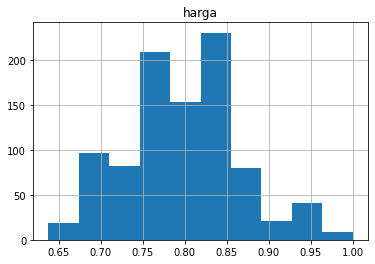

In [9]:
_ = chicken_df.hist()

In [10]:
#Get the price and time step from dataframe
temp = chicken_df['harga']
price = np.array(temp.tolist())
time = np.array([i[0] for i in enumerate(price)])

In [11]:
#Helper function for plotting dataset
def plot_dataset(time, series, title, xlabel, ylabel, color='b'):
  plt.plot(time, series, '{}-'.format(color))
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.grid=True

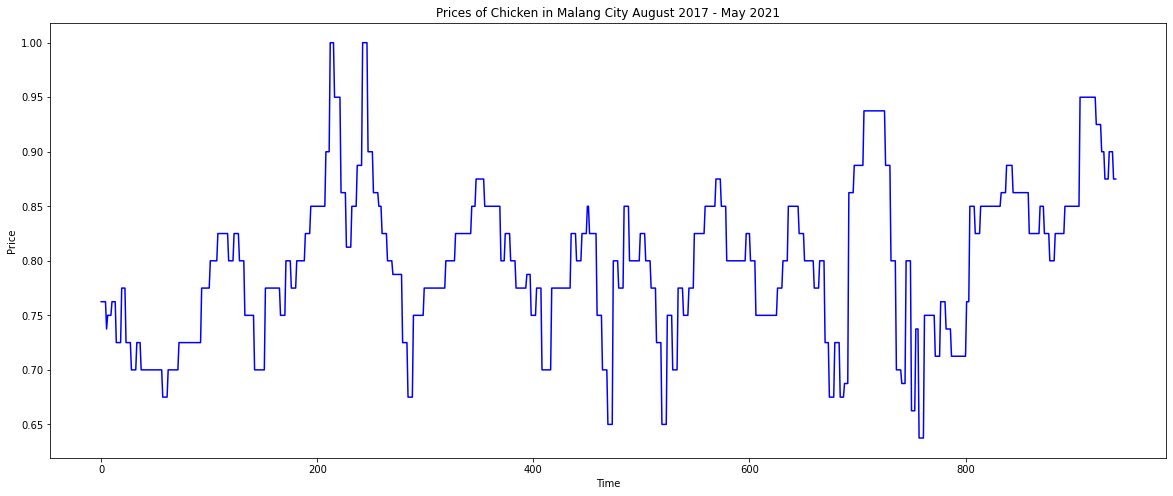

In [12]:
#Plot the dataset
plt.figure(figsize=(20, 8))
plot_dataset(time=time, series=price, color='b', title='Prices of Chicken in Malang City August 2017 - May 2021', xlabel='Time', ylabel='Price')

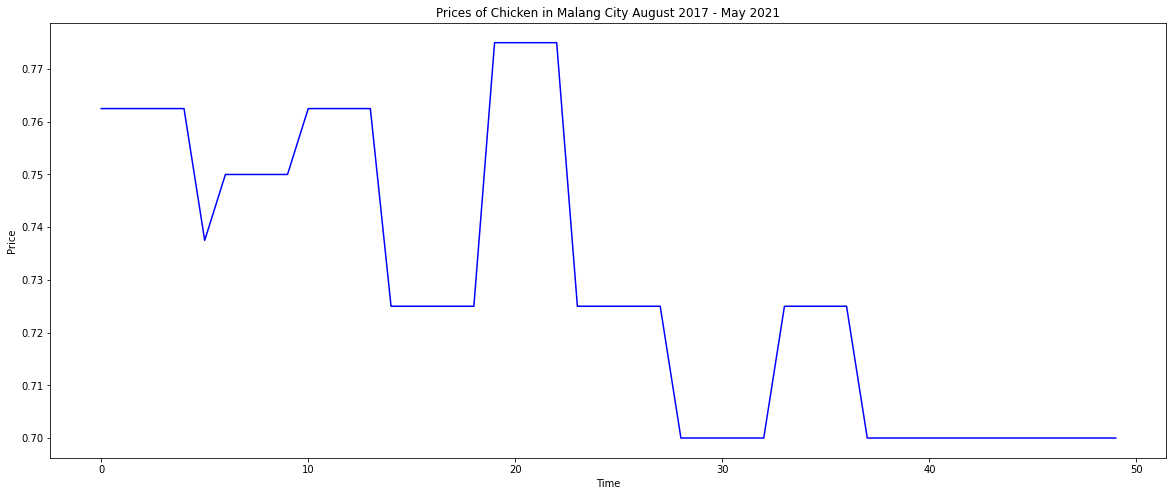

In [13]:
#Plot the dataset
plt.figure(figsize=(20, 8))
plot_dataset(time=time[:50], series=price[:50], color='b', title='Prices of Chicken in Malang City August 2017 - May 2021', xlabel='Time', ylabel='Price')

Split Train and Test

In [14]:
#Split dataset with 70% of training, 20% for validation, and the rest for testing
split = round(0.7*len(price))
split_val = round(0.9*len(price))
train_price = price[:split]
train_time = time[:split]
val_price = price[split:split_val]
val_time = time[split:split_val]
test_price = price[split_val:]
test_time = time[split_val:]

Window the dataset

In [15]:
#Helper function for windowing the dataset
def dataset_window(list, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(temp, axis=-1)
  data_window = tf.data.Dataset.from_tensor_slices(series)
  data_window = data_window.window(window_size + 1, shift = 1, drop_remainder= True)
  data_window = data_window.flat_map(lambda x: x.batch(window_size+1))
  data_window = data_window.shuffle(shuffle_buffer)
  data_window = data_window.map(lambda x: (x[:-1], x[1:]))
  data_window = data_window.batch(batch_size).prefetch(1)
  return data_window

Function for Forecasting the Model for Fit It Into the Plotted Graph

In [16]:
#Helper function for forecasting
def forecast_model(model, series, window_size):
  data_forecast = tf.data.Dataset.from_tensor_slices(series)
  data_forecast = data_forecast.window(window_size, shift=1, drop_remainder=True)
  data_forecast = data_forecast.flat_map(lambda x: x.batch(window_size))
  data_forecast = data_forecast.batch(32).prefetch(1)
  forecast = model.predict(data_forecast)
  return forecast

Window Size, Batch Size, & Shuffle Buffer Variable

In [17]:
window_size = 50
batch_size = 512
shuffle_buffer = 950

Build the Model

In [18]:
#Building model with learning rate scheduler, so we can pick the best learning rate
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = dataset_window(train_price, window_size, batch_size, shuffle_buffer)

print(train_set)
print(train_price.shape)

model = tf.keras.models.Sequential([
          tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1,
                                 padding='causal', activation='relu',
                                 input_shape=[None,1]),
          tf.keras.layers.LSTM(32, return_sequences=True),
          tf.keras.layers.Dense(15, activation='relu'),
          tf.keras.layers.Dense(1),
])
learning_rate_scheduler = tf.keras.callbacks.LearningRateScheduler(
    lambda x: 1e-8 * 10**(x/20))
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9),
              metrics=[tf.metrics.MeanAbsoluteError()])
history = model.fit(train_set, epochs=200, callbacks=[learning_rate_scheduler])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float32, tf.float32)>
(658,)
Epoch 1/200
2/2 [==============================] - 33s 85ms/step - loss: 0.2950 - mean_absolute_error: 0.7653
Epoch 2/200
2/2 [==============================] - 0s 18ms/step - loss: 0.2950 - mean_absolute_error: 0.7653
Epoch 3/200
2/2 [==============================] - 0s 11ms/step - loss: 0.2950 - mean_absolute_error: 0.7653
Epoch 4/200
2/2 [==============================] - 0s 18ms/step - loss: 0.2950 - mean_absolute_error: 0.7653
Epoch 5/200
2/2 [==============================] - 0s 16ms/step - loss: 0.2950 - mean_absolute_error: 0.7653
Epoch 6/200
2/2 [==============================] - 0s 15ms/step - loss: 0.2950 - mean_absolute_error: 0.7653
Epoch 7/200
2/2 [==============================] - 0s 10ms/step - loss: 0.2950 - mean_absolute_error: 0.7653
Epoch 8/200
2/2 [==============================] - 0s 17ms/step - loss: 0.2950 - mean_absolute_error: 0.7653
Epoch 9/200
2/2 [=========

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
lstm (LSTM)                  (None, None, 32)          8320      
_________________________________________________________________
dense (Dense)                (None, None, 15)          495       
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           16        
Total params: 9,023
Trainable params: 9,023
Non-trainable params: 0
_________________________________________________________________


(1e-05, 0.1, 0.0, 1.0)

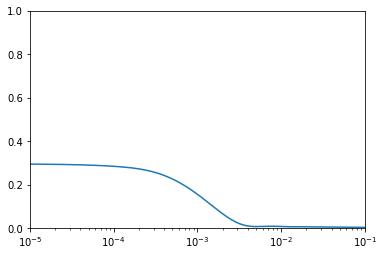

In [20]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-5, 1e-1, 0, 1])

In [22]:
#Build the final model with the best learning rate
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = dataset_window(train_price, window_size, batch_size, shuffle_buffer)
val_set = dataset_window(val_price, window_size, batch_size, shuffle_buffer)
print(train_set)
print(train_price.shape)

model = tf.keras.models.Sequential([
          tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1,
                                 padding='causal', activation='relu',
                                 input_shape=[None,1]),
          tf.keras.layers.LSTM(32, return_sequences=True),
          tf.keras.layers.Dense(15, activation='relu'),
          tf.keras.layers.Dense(1),
])
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=tf.keras.optimizers.SGD(learning_rate=1e-1, momentum=0.9),
              metrics=[tf.metrics.MeanAbsoluteError()])
history = model.fit(train_set, epochs=500, validation_data=val_set)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float32, tf.float32)>
(658,)
Epoch 1/500
2/2 [==============================] - 2s 558ms/step - loss: 0.1952 - mean_absolute_error: 0.6064 - val_loss: 0.0097 - val_mean_absolute_error: 0.0861
Epoch 2/500
2/2 [==============================] - 0s 156ms/step - loss: 0.0321 - mean_absolute_error: 0.1934 - val_loss: 0.1118 - val_mean_absolute_error: 0.4538
Epoch 3/500
2/2 [==============================] - 0s 170ms/step - loss: 0.0836 - mean_absolute_error: 0.3834 - val_loss: 0.0040 - val_mean_absolute_error: 0.0670
Epoch 4/500
2/2 [==============================] - 0s 146ms/step - loss: 0.0095 - mean_absolute_error: 0.1112 - val_loss: 0.0362 - val_mean_absolute_error: 0.2604
Epoch 5/500
2/2 [==============================] - 0s 148ms/step - loss: 0.0379 - mean_absolute_error: 0.2666 - val_loss: 0.0277 - val_mean_absolute_error: 0.2256
Epoch 6/500
2/2 [==============================] - 0s 148ms/step - loss: 0.0213 - me

In [23]:
#Forecasting the testing data
rnn_forecast = forecast_model(model, price[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_val - window_size:-1, -1, 0]

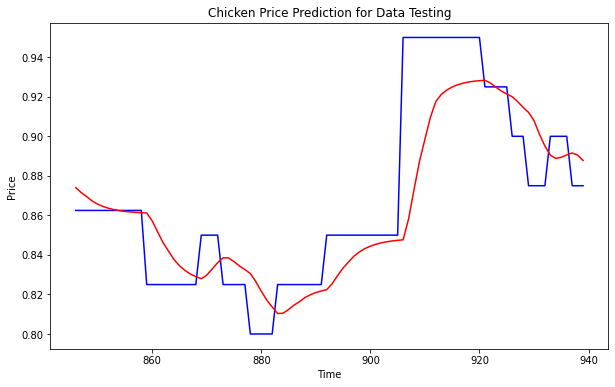

In [24]:
#Plotting the testing data
plt.figure(figsize=(10, 6))
plot_dataset(time=test_time, series=test_price, title='Chicken Price Prediction for Data Testing',xlabel='Time', ylabel='Price')
plot_dataset(time=test_time, series=rnn_forecast, title='Chicken Price Prediction for Data Testing', xlabel='Time', ylabel='Price', color='r')

<Figure size 432x288 with 0 Axes>

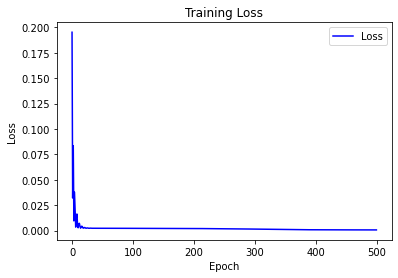

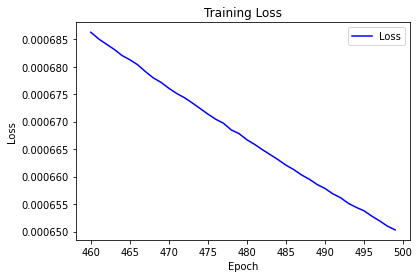

<Figure size 432x288 with 0 Axes>

In [25]:
#Plotting and examining the training loss
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

loss=history.history['loss']

epoch_num=range(len(loss))

plot_dataset(epoch_num, loss, title='Training Loss', xlabel='Epoch', ylabel='Loss')
plt.legend(["Loss"])
plt.figure()

loss_zoom = loss[460:]
epoch_num_zoom = [x+460 for x in range(len(loss_zoom))]

plot_dataset(epoch_num_zoom, loss_zoom, title='Training Loss', xlabel='Epoch', ylabel='Loss')
plt.legend(["Loss"])
plt.figure()

In [27]:
temp = len(test_price)-21
temp_1 = len(test_price)-1
temp=test_price[temp:temp_1]

In [28]:
rnn_forecast = forecast_model(model, temp[..., np.newaxis],len(temp)).tolist()
rnn_forecast

[[[0.8000738620758057],
  [0.8122933506965637],
  [0.8401502966880798],
  [0.8532049059867859],
  [0.8798844218254089],
  [0.894136905670166],
  [0.9021987915039062],
  [0.9046227931976318],
  [0.904030442237854],
  [0.9024376273155212],
  [0.898392379283905],
  [0.8928784728050232],
  [0.8880158066749573],
  [0.8842369318008423],
  [0.8833037614822388],
  [0.884460985660553],
  [0.8861598372459412],
  [0.8876226544380188],
  [0.8869093060493469],
  [0.8846174478530884]]]

In [29]:
round(rnn_forecast[-1][-1][0]*max)

35385

In [30]:
model.save("chicken_model")

INFO:tensorflow:Assets written to: chicken_model/assets


INFO:tensorflow:Assets written to: chicken_model/assets


In [31]:
!zip -r chicken_model.zip chicken_model

  adding: chicken_model/ (stored 0%)
  adding: chicken_model/assets/ (stored 0%)
  adding: chicken_model/keras_metadata.pb (deflated 89%)
  adding: chicken_model/saved_model.pb (deflated 90%)
  adding: chicken_model/variables/ (stored 0%)
  adding: chicken_model/variables/variables.data-00000-of-00001 (deflated 20%)
  adding: chicken_model/variables/variables.index (deflated 63%)
